Este documento se encontra no repositório público 
https://github.com/obabilonia/case_santander_data_master

Introdução:
Este trabalho foi definido na segunda fase do programa de certificação Data-Master do banco Santander Brasil. Nesta fase foi definido o desenvolvimento de um case pratico que consiste de 3 tarefas:
<br>

1. A primeira tarefa deste case é maximizar o lucro esperado por cliente considerando o conceito de identificação e retenção de clientes insatisfeitos.
2. A segunda tarefa consiste em dar uma nota de 1 a 5 para cada cliente da base teste, respeitando a variável ‘TARGET’, isto é, o seu nível de satisfação, sendo 1 o mais insatisfeito e 5 o mais satisfeito. Ao dar essa nota deve-se ter em mente que somente os clientes com nota 1 serão alvos de uma ação de retenção e que o objetivo dessa ação é maximizar o lucro esperado por cliente (usando os mesmos valores da primeira questão).
3. Todo conjunto de dados é passível de ser dividido em grupos coesos, conhecidos como agrupamentos naturais. A terceira tarefa é encontrar os três grupos naturais que possuem os maiores lucros esperados por cliente (usando os mesmos valores da primeira questão).

Cabe ressaltar que o case definido é um desafio Kaggle, e com uma exploração superficial no próprio desafio e em repositórios públicos é fácil achar diferentes soluções já propostas (com os respectivos códigos). Como é o caso do trabalho apresentado por Caio Martins (CaioMar) https://github.com/CaioMar/certificao_data_masters/blob/master/Certificacao%20Data%20Masters.ipynb
<br>
Por isso, neste trabalho o foco principal não será apresentar uma solução já encontrada, e sim a apresentação de uma abordagem diferente das já publicadas, tentando  apresentar novos insights utilizando os trabalhos prévios como base.
Também ressaltamos que na prática, não aplicariamos o passo a passo aqui empregado dado que entendemos que alguns dos métodos não são os mais eficiente, aqui o objetivo é mais didático ao invés de prático.  
<br>
Resumo:
As abordagens apresentadas são definidas conforme segue:
<br>
#### Parte 1:
1. Exploração e comentários sobre a variável resposta.
2. Tratamento 1: Remoção de features com variância zero
3. Tratamento 2: Remoção de features duplicadas
4. Split do dataset em teste e treino
5. Seleção do modelo RandomForest e Tuning de Hiperparametros
6. Treinamento e teste do primeiro modelo
7. Tratamento 3: Remoção de features com variância próxima a zero
8. Tratamento 4: Remoção de features quase duplicadas (altamente correlacionadas)
9. Retreinamento e teste do modelo

#### Parte 2:
1. Utilização do método predict_proba(), e apresentação da histograma de probabilidades
2. Calculo e representação do ROC e AUC
3. Definição de grupos de clientes segundo probabilidade de ser clientes insatisfeitos

#### Parte 3:
1. Reescalhamento das features
2. Aplicação do K-means
3. Representação gráfica do Elbow curve e Silhouttes
4. Escolha do melhor K e segmentação dos clientes
5. Avaliação de resultados

#### Extra:
1. Tratamento e teste de variáveis categóricas
2. Aplicação e teste de métodos Undersampling e Oversampling
3. Referencias


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-satisfaction/sample_submission.csv
/kaggle/input/santander-customer-satisfaction/train.csv
/kaggle/input/santander-customer-satisfaction/test.csv


In [2]:
#pd.read_csv('/kaggle/input/santander-customer-satisfaction/sample_submission.csv')

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.style.use('ggplot')

%matplotlib inline

from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import euclidean_distances
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer, f1_score, fbeta_score, roc_auc_score, auc, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold

from time import time

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
def see_categories(data, target):
    count = pd.DataFrame(data[target].value_counts())
    percent = pd.DataFrame(data[target].value_counts(normalize=True)*100)
    table = pd.concat([count, percent], axis=1)
    table.columns = ['qtd', 'perc']
    return table.sort_values('perc', ascending=False)

In [5]:
def corr_heatmap (data, figsize_1= 10, figsize_2 = 10, see_numbers= False):
    fig, plot = plt.subplots(figsize=(figsize_1, figsize_2)) 
    plot = sns.heatmap(pd.DataFrame.corr(data), linewidths=0.3, annot = see_numbers)
    return plot

In [6]:
data = pd.read_csv('/kaggle/input/santander-customer-satisfaction/train.csv')
df_test = pd.read_csv('/kaggle/input/santander-customer-satisfaction/test.csv')

print(data.shape, df_test.shape) 

(76020, 371) (75818, 370)


In [7]:
data.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

- Uma olhada rapida no dataset nos permite identificar, primeiramente que as variaveis ID e TARGET podem ser retiradas para definir nossa lista de features iniciais. Entretanto, observamos que aparentemente todas as features são numericas. consequentemente não será necesaria a aplicação de métodos de encoding.

In [8]:
target = 'TARGET'
all_features = data.iloc[:,1:-1].columns #retiramos IDs e Target

- Observemos como se encontra distribuida nossa variavel dependente

<AxesSubplot:>

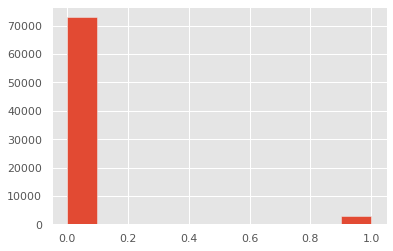

In [9]:
# Histograma da Target
data[target].hist()

In [10]:
see_categories(data, target)

,qtd,perc
0,73012,96.043147
1,3008,3.956853


<h1> comentarios sobre o desbalanceamento</h1>

Conforme definido no case, a marcação de 1 indica clientes insatisfeitos e 0 indica clientes satisfeitos <br>
Como era esperado, a gente como instituição oferece um excelente serviço, por isso a quantidade de clientes satisfeitos é muito maior que os insatisfeitos, o qual faz sentido, e consequentemente o desvalanceamento até que era esperado.<br>
Entretanto, dado desbalanceamento nos obriga a tomar cuidado com certas ações que tomaremos mais adiante como são: 
- Ao momento de splitar os dados nos datasets train e test é fortemente recomendo utilizar stratificação (stratify) para evitar que exista maior proporção de classes possitivas em um dos datasets.
- A definição da metrica de avaliação do modelo. Gini, F1-score, ou AUC são boas metricas de classificação onde existe desbalanceamento nos dados. 
- No caso do modelo Random Forest será necessario utilizar o hiperparámetros "class_weight" para controlar o desbalanceamento.
- Recomendado utilizar métodos de UNDERSAMPLING ou OVERSAMPLING.

In [144]:
X_all = data[all_features] 
y_all = data[target]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify = y_all, test_size = 0.20 ,random_state = 1234)

print("Training set has {} samples and {} features.".format(X_train.shape[0], X_train.shape[1]))
print("Testing set has {} samples and {} features.".format(X_test.shape[0], X_test.shape[1]))
print("Train target {:0.5f}%".format(y_train.sum()/y_train.shape[0]))
print("Test target {:0.5f}%".format(y_test.sum()/y_test.shape[0]))

Training set has 60816 samples and 369 features.
Testing set has 15204 samples and 369 features.
Train target 0.03956%
Test target 0.03959%


- Estratificação no target feita com sucesso

## Verificação de nulos e valores unicos

- O dataset aparentemente não possui valores nulos, entretanto foi observado a existencia do valor -999999 sendo frequente em algumas variaveis o que levanta a suspeita de que alguem previamente preencheu os valores nulos com o valor -999999 (é uma hipotese).

- Também obsevamos que existem colunas sem variancia ou variancia muito próxima a zero (aquelas cuja concentração são maioritariamente em uma unica classe).

- Embora estejamos trabalhando com dados númericos, também é esperado que existam variaveis binarias ou categóricas, aquelas que possuim 2 classes ou poucas classes diferentes.

In [12]:
def get_uniques(df):
    len_array = []
    concentration_array = []
    for var in df.columns:
        current_len  = len(df[var].unique())
        len_array.append(current_len)
        concentration  = df[var].value_counts().iloc[0]/df.shape[0]
        concentration_array.append(concentration)

    missing = pd.DataFrame(np.array(df.isnull().sum()), columns = ['missing'])
    p_missing = missing / df.shape[0]
    
    

    qtd = pd.concat([pd.DataFrame(df.columns), pd.DataFrame(len_array), pd.DataFrame(concentration_array), missing.missing, pd.DataFrame(p_missing)], axis = 1)
    qtd.columns = ['var', 'qtd_unique_values', 'concentration', 'qtd_missing','perc_missing']

    return qtd

qtd = get_uniques(X_train)

qtd.sort_values('qtd_unique_values')

,var,qtd_unique_values,concentration,qtd_missing,perc_missing
315,num_trasp_var17_out_hace3,1,1.000000,0,0.0
131,num_var27_0,1,1.000000,0,0.0
234,imp_reemb_var13_hace3,1,1.000000,0,0.0
236,imp_reemb_var17_hace3,1,1.000000,0,0.0
327,saldo_var2_ult1,1,1.000000,0,0.0
238,imp_reemb_var33_hace3,1,1.000000,0,0.0
349,saldo_medio_var13_medio_hace3,1,1.000000,0,0.0
261,num_var2_0_ult1,1,1.000000,0,0.0
162,num_var46,1,1.000000,0,0.0
161,num_var46_0,1,1.000000,0,0.0


Por enquanto só retiraremos as colunas sem variancia e colunas duplicadas.

In [13]:
zero_variance = list(qtd[qtd['qtd_unique_values'] == 1]['var'])
len(zero_variance)

36

In [14]:
selected_features = list(set(X_train.columns) - set(zero_variance))
len(selected_features)

333

In [15]:
aux = []
aux2 = {}
c = selected_features
for i in range(len(c)-1):
    if c[i] not in list(dict.fromkeys(sum(aux2.values(), []))):
        v = X_train[c[i]].values
        aux2[c[i]] = []
        for j in range(i+1,len(c)):
            if np.array_equal(v,X_train[c[j]].values):
                aux.append([c[i], c[j]])
                aux2[c[i]].append(c[j])

for i in aux2:
    if len(aux2[i]) >= 1:
        print(i, '\t', aux2[i])
        
duplicate_vars = list(dict.fromkeys(sum(aux2.values(), [])))
len(duplicate_vars)

num_var39 	 ['num_var40']
delta_num_trasp_var33_in_1y3 	 ['delta_imp_trasp_var33_in_1y3']
ind_var13_medio_0 	 ['ind_var13_medio']
num_var29_0 	 ['num_var6_0']
delta_imp_reemb_var13_1y3 	 ['delta_num_reemb_var13_1y3']
ind_var32_0 	 ['ind_var32']
ind_var18 	 ['ind_var18_0']
delta_imp_reemb_var17_1y3 	 ['delta_num_reemb_var17_1y3']
num_var34_0 	 ['num_var34']
ind_var34 	 ['ind_var34_0']
delta_num_trasp_var33_out_1y3 	 ['delta_imp_trasp_var33_out_1y3']
num_var25_0 	 ['num_var25']
delta_imp_trasp_var17_out_1y3 	 ['delta_num_trasp_var17_out_1y3']
delta_num_reemb_var33_1y3 	 ['delta_imp_reemb_var33_1y3']
delta_imp_trasp_var17_in_1y3 	 ['delta_num_trasp_var17_in_1y3']
saldo_medio_var13_medio_ult1 	 ['saldo_var13_medio']
saldo_var6 	 ['saldo_var29']
ind_var26_0 	 ['ind_var26']
ind_var29 	 ['ind_var6']
ind_var39 	 ['ind_var40']
ind_var37_0 	 ['ind_var37']
num_var13_medio_0 	 ['num_var13_medio']
ind_var6_0 	 ['ind_var29_0']
num_var37_0 	 ['num_var37']
num_var26_0 	 ['num_var26']
num_var29 	 ['num

29

In [16]:
selected_features = list(set(X_train.columns) 
                         - set(zero_variance) 
                         - set(duplicate_vars)
                        )
len(selected_features)

304

# Tarefa 1 (Maximizar o Lucro)

- Agora definiremos nossa função de custo/ganho a qual procuraremos minimizar/maximizar. (Neste caso iremos a maximizar o lucro conforme regras de negocio)
- Regras de negocio:
 - O custo de preparar e executar uma ação de retenção é um valor fixo de R$ 10 por cliente.
 - Um verdadeiro positivo é um cliente que estava insatisfeito e foi alvo de uma ação de retenção. O benefício neste caso é o lucro da ação (R\\$ 100) menos os custos relacionados à ação de retenção (R\\$ 10).
 - Um verdadeiro negativo é um cliente insatisfeito e que não é alvo de nenhuma ação. O benefício neste caso é zero, isto é, nenhum custo, mas nenhum lucro.
 - Um falso positivo ocorre quando classificamos um cliente como insatisfeito, mas ela não se comporta como tal, neste caso o valor da ação de retenção será perdido.
 - Um falso negativo ocorre quando um cliente é previsto como satisfeito, mas na verdade ele estava insatisfeito. Neste caso, nenhum dinheiro foi gasto e nada foi ganho.

Nossa função de lucro vai depender unicamente dos classificados como falsos possitivos (FP) e verdadeiros possitivos (TP). Para obter os FP e VP utilizamos a função confusion_matrix().

In [17]:
# Funcao proposta por CaioMar 
def max_profit_score(y_true, y_pred):
    """
    Função que avalia o modelo computando o lucro esperado
    da ação de retenção dos clientes insatisfeitos.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    FP = conf_matrix[0][1] # Falsos positivos
    TP = conf_matrix[1][1] # Verdadeiros positivos
    
    lucro = 90*TP - 10*FP # lucro da acao de retencao (os 
                          # verdadeiros e falsos negativos
                          # não contribuem em
                          # nada no lucro)
    
    return lucro


def show_performance_2(clf, X, y_true):
    y_pred = clf.predict(X)
    lucro_max_possible = max_profit_score(y_true,y_true)
    return 100*max_profit_score(y_true, y_pred)/lucro_max_possible


def show_performance(clf, X, y_true):
    y_pred = clf.predict(X)
    lucro_max_possible = max_profit_score(y_true,y_true)
    if str(type(clf)) == "<class 'lightgbm.basic.Booster'>":
        y_pred = (clf.predict(X_test) > 0.5)*1
    print('Matriz de confusão:')
    print(confusion_matrix(y_true, y_pred))
    print('\nLucro obtido com a ação (em Reais): R$ {} '.format(max_profit_score(y_true, y_pred)))
    print('Lucro maximo possivel: R$ {} '.format(lucro_max_possible))
    print('Porcentagem do lucro maximo: {:0.2f}%'.format(100*max_profit_score(y_true, y_pred)/lucro_max_possible))
    print('')


max_profit_scorer = make_scorer(max_profit_score, greater_is_better=True)

print('Lucro máximo possivel na partição de treino: {}'.format(max_profit_score(data[target], data[target])))
print('Lucro máximo possivel na partição de teste: {}'.format(max_profit_score(y_test, y_test)))

Lucro máximo possivel na partição de treino: 270720
Lucro máximo possivel na partição de teste: 54180


Procedemos a treinar nosso modelo, e como ponto de partida utilizamos um RandomForestClassifier. por que Random Forest? particularmente sempre recomendamos iniciar com RandomForest dado que ele oferece boa performance com um baixo custo de treinamento, é altamente paralelizavel, performa bem inclusive quando os dados possuim pouco tratamento e é robusto a outliers, trabalha bem com variaveis contínuas e categoricas, entre outras vantagens. 

Um passo importante e cruzial na hora de instanciar qualquer modelo é a escolha dos hiperparametros, isso pode ser um motivo que diferencia um modelo bom e um ruim. Um metodo que funciona muito bem que é muito conhecido é GridSearchCV que seria o equivalente a aplicar "forza bruta". Entretanto, neste momento optaremos por utilizar scikit-Optimize (SKOPT). SKOPT providencia uma estrutura para tuning de hiperparametros pela abordagem de otimização bayesiana. Alguns trabalhos cientificos provam que otimização bayesiana é mais eficiente que grid search atingindo modelos de igual ou melhor performance.

Para entender o conceito e o efeito dos hiperparametros do RandomForest é recomendada a leitura da referencia https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/.

Definiremos alguns parametros, que pasaremos ao modelo para ele entender melhor o que estamos tentando otimizar. 
Neste é utilizada a função make_score para indicar ao modelo que temos que maximizar nossa função de lucro (greater_is_better=True) conforme indicado pelo CaioMar.

In [21]:
%%time 

import skopt
from sklearn.model_selection import cross_val_score

def tune_rf(params):
    """Function to be passed as scikit-optimize minimizer/maximizer input
    
    Parameters:
    Tuples with information about the range that the optimizer should use for that parameter, 
    as well as the behaviour that it should follow in that range.
    
    Returns:
    float: the metric that should be minimized. If the objective is maximization, then the negative 
    of the desired metric must be returned. In this case, the negative AUC average generated by CV is returned.
    """
    
    
    #Hyperparameters to be optimized
    print(params)
    max_depth = params[0] 
    n_estimators = params[1] 
    class_weight = params[2]
    min_samples_split = params[3]
    max_features = params[4]

        
    
    #Model to be optimized
    model = RandomForestClassifier(
                            max_depth = max_depth,
                            n_estimators = n_estimators,
                            class_weight = {0:1,1:class_weight},
                            min_samples_split = min_samples_split,
                            max_features = max_features,
                            n_jobs=-1,
                            random_state=1234
            )
    

    

    
    #Cross-Validation in order to avoid overfitting
    lucro_perc = cross_val_score(model, X_train[selected_features], y_train, cv = 5, scoring = max_profit_scorer)
    
    print(lucro_perc.mean())
    # as the function is minimization (forest_minimize), we need to use the negative of the desired metric (AUC)
    return -lucro_perc.mean()


space = [(18, 19), # max_depth
          (46, 47), # n_estimators
          (10,15), # class_weight 
          (int(X_train.shape[0]*0.005), int(X_train.shape[0]*0.01)), # min_samples_split 
          ('auto','log2', 40)] # max_features



result = skopt.forest_minimize(tune_rf, space, random_state=42, n_random_starts=20, n_calls=50, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[19, 46, 12, 375, 'log2']
10332.0
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.1835
Function value obtained: -10332.0000
Current minimum: -10332.0000
Iteration No: 2 started. Evaluating function at random point.
[18, 47, 12, 518, 'auto']
10934.0
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.9355
Function value obtained: -10934.0000
Current minimum: -10934.0000
Iteration No: 3 started. Evaluating function at random point.
[19, 46, 13, 455, 'log2']
10544.0
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.8197
Function value obtained: -10544.0000
Current minimum: -10934.0000
Iteration No: 4 started. Evaluating function at random point.
[18, 47, 13, 597, 'auto']
10818.0
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.1036
Function value obtained: -10818.0000
Current minimum: -10934.0000
Iteration No: 5 started. Evaluating function at r

In [22]:
param = ['max_depth        ', 
         'n_estimators     ', 
         'class_weight     ', 
         'min_samples_split', 
         'min_samples_split', 
         'max_features     '
        ]

for i in range(0, len(result.x)): 
    print('{} \t {}'.format(param[i], result.x[i]))

max_depth         	 19
n_estimators      	 47
class_weight      	 15
min_samples_split 	 345
min_samples_split 	 40


In [23]:
model = RandomForestClassifier(
                        max_depth = result.x[0],
                        n_estimators = result.x[1],
                        class_weight = {0:1,1:result.x[2]},
                        min_samples_split = result.x[3],
                        max_features = result.x[4],
                        n_jobs=-1,
                        random_state=1234
        )



model.fit(X_train[selected_features], y_train)

bst_max_profit_model = model

print('treino:')
show_performance(bst_max_profit_model, X_train[selected_features], y_train)

print('test:')
show_performance(bst_max_profit_model, X_test[selected_features], y_test)

treino:
Matriz de confusão:
[[51512  6898]
 [  777  1629]]

Lucro obtido com a ação (em Reais): R$ 77630 
Lucro maximo possivel: R$ 216540 
Porcentagem do lucro maximo: 35.85%

test:
Matriz de confusão:
[[12810  1792]
 [  233   369]]

Lucro obtido com a ação (em Reais): R$ 15290 
Lucro maximo possivel: R$ 54180 
Porcentagem do lucro maximo: 28.22%



In [46]:
%%time
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1234)

gs_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=1234, n_jobs=-1), 
                       param_grid = {'max_depth':[18],
                                     'n_estimators':[47],
                                     'criterion': ['gini'],
                                     'class_weight':[{0:1,1:12}, {0:1,1:13}, {0:1,1:14}], 
                                     'min_samples_split':[int(X_train.shape[0]*0.01),
                                                          int(X_train.shape[0]*0.005)],
                                     'max_features':['auto','log2', 40]
                                     }, 
                       scoring=max_profit_scorer, 
                       cv=skf.split(X_train[selected_features], y_train), 
                       n_jobs=-1, 
                       verbose=5)

gs_rf.fit(X_train[selected_features], y_train)


best_rf = gs_rf.best_estimator_

print('treino:')
show_performance(best_rf, X_train[selected_features], y_train)

print('test:')
show_performance(best_rf, X_test[selected_features], y_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.9min finished


treino:
Matriz de confusão:
[[52009  6401]
 [  894  1512]]

Lucro obtido com a ação (em Reais): R$ 72070 
Lucro maximo possivel: R$ 216540 
Porcentagem do lucro maximo: 33.28%

test:
Matriz de confusão:
[[12948  1654]
 [  246   356]]

Lucro obtido com a ação (em Reais): R$ 15500 
Lucro maximo possivel: R$ 54180 
Porcentagem do lucro maximo: 28.61%

CPU times: user 20.3 s, sys: 680 ms, total: 20.9 s
Wall time: 3min 59s


Só com a retirada de colunas sem variancia e duplicadas obtemos um lucro de 28.24% do lucro máximo possivel na partição de teste.

Agora procedemos a retirar as features com variancias próximas a zero.

In [24]:
qtd = get_uniques(X_train[selected_features])
near_zero_variance = qtd[qtd['concentration'] >= 0.995]
#near_zero_variance.sort_values('concentration')

In [25]:
features_nzv = list(near_zero_variance['var'])
len(features_nzv)

149

In [26]:
selected_features = list(set(X_train.columns) 
                         - set(zero_variance) 
                         - set(duplicate_vars) 
                         - set(features_nzv)
                        )
len(selected_features)

155

In [27]:
model.fit(X_train[selected_features], y_train)

print('treino:')
show_performance(model, X_train[selected_features], y_train)

print('test:')
show_performance(model, X_test[selected_features], y_test)

treino:
Matriz de confusão:
[[51211  7199]
 [  725  1681]]

Lucro obtido com a ação (em Reais): R$ 79300 
Lucro maximo possivel: R$ 216540 
Porcentagem do lucro maximo: 36.62%

test:
Matriz de confusão:
[[12752  1850]
 [  229   373]]

Lucro obtido com a ação (em Reais): R$ 15070 
Lucro maximo possivel: R$ 54180 
Porcentagem do lucro maximo: 27.81%



Apos a remoção de 149 features com variancia quase zero e mantendo os mesmos hiperparametros do modelo é observado uma diminuição da performance, resaltamos que dita diminuição não é alarme para voltar atrás, e alguns pontos devem ser discutidos. Primeiramente resaltamos que os hiperparametros se mantiveram constantes, tal vez um fine-tunning seria uma boa abordagem, isso porque é aconselhado que alguns hiperparametros sejam definidos em função do número de features (controle de overfittinng underfitting). Agora, uma outra sugestão seria criar uma nova feature pela combinação linear das variaveis removidas, isso a fim de manter a combinação das poucas variancias observadas nas features retiradas, isso também seria interessante principalmente para este tipo de problemas onde existe um grande desvalanceamento (vai que a pouca variancia retirada se encontre concentrada nas observações de classe possitiva).

Também retiramos as colunas "quase-duplicadas", isto é as que possuim um valor de correlação muito elevada. Neste casso utilizamos o calculo de correlação de Pearson e um thread de 0.95 (sendo que 1 é correlação perfeita = duplicada)

In [28]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, thread=0.95):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    df_result = pd.DataFrame(au_corr).reset_index()
    df_result.columns = ['level_0', 'level_1', 'corr']
    return df_result[df_result['corr'] > thread]

#print("Top Absolute Correlations")
get_top_abs_correlations(X_train[selected_features], 0.95)

,level_0,level_1,corr
0,num_var8,ind_var8,1.000000
1,delta_imp_aport_var13_1y3,delta_num_aport_var13_1y3,1.000000
2,ind_var8_0,num_var8_0,0.999742
3,num_var13_corto,ind_var13_corto,0.999589
4,num_var24,ind_var24,0.999554
5,num_op_var39_efect_ult3,num_op_var41_efect_ult3,0.999294
6,ind_var40_0,num_var40_0,0.999279
7,imp_op_var39_efect_ult3,imp_op_var41_efect_ult3,0.999129
8,num_op_var41_efect_ult1,num_op_var39_efect_ult1,0.998815
9,ind_var1_0,num_var1_0,0.998570


Observamos 69 pares de variaveis altamente correlacionadas. Isso não significa que iremos a excluir 68, isso é porque podem existir correlações cruzada (3 ou mais variaveis altamente correlacionadas que geram combinações de pares, neste casso excluimos todas exceto 1).

<AxesSubplot:>

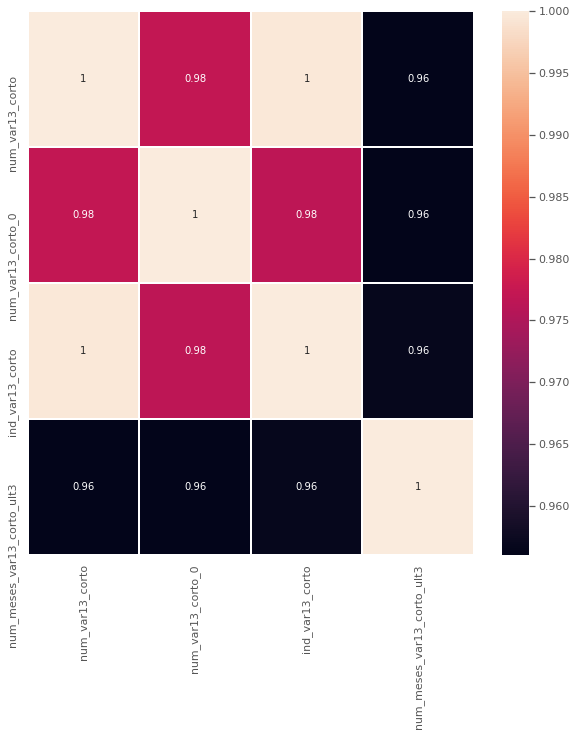

In [29]:
corr_heatmap(X_train[['num_var13_corto', 'num_var13_corto_0', 'ind_var13_corto', 'num_meses_var13_corto_ult3']], 
             figsize_1= 10, 
             figsize_2 = 10, 
             see_numbers= True
            )
#Exemplo de correlação cruzada

A seguir calculamos a lista de features a ser excluida, sendo um total de 51.

In [30]:
cor_matrix = X_train[selected_features].corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
hight_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(hight_corr)
print(len(hight_corr))

['num_var5', 'ind_var13_0', 'ind_var1_0', 'ind_var12', 'imp_op_var41_comer_ult3', 'delta_num_aport_var13_1y3', 'ind_var13_corto_0', 'num_op_var39_ult3', 'imp_op_var41_efect_ult3', 'saldo_var24', 'saldo_medio_var12_ult3', 'num_var25_0', 'saldo_medio_var13_corto_ult1', 'num_op_var41_hace2', 'ind_var39_0', 'num_var8_0', 'ind_var9_cte_ult1', 'saldo_medio_var13_corto_ult3', 'num_var4', 'num_op_var39_ult1', 'num_var13_corto_0', 'imp_op_var39_ult1', 'ind_var13_largo_0', 'num_med_var45_ult3', 'ind_var14', 'num_meses_var12_ult3', 'ind_var8', 'num_var40_0', 'num_op_var39_efect_ult1', 'num_op_var41_comer_ult3', 'num_var39_0', 'num_var24_0', 'num_meses_var13_corto_ult3', 'saldo_medio_var13_largo_ult3', 'saldo_medio_var8_ult3', 'saldo_var25', 'ind_var24', 'num_op_var41_hace3', 'imp_op_var41_efect_ult1', 'num_op_var41_efect_ult3', 'saldo_var42', 'num_var13', 'num_var1_0', 'num_op_var41_comer_ult1', 'ind_var26_0', 'imp_op_var41_comer_ult1', 'ind_var13_corto', 'ind_var26_cte', 'saldo_medio_var12_ult1'

In [142]:
selected_features = list(
                        set(X_train.columns) 
                        - set(zero_variance) 
                        - set(duplicate_vars)
                        - set(features_nzv) 
                        - set(hight_corr)
                        )
len(selected_features)

104

In [35]:
model.fit(X_train[selected_features], y_train)

print('treino:')
show_performance(model, X_train[selected_features], y_train)

print('test:')
show_performance(model, X_test[selected_features], y_test)

treino:
Matriz de confusão:
[[51308  7102]
 [  725  1681]]

Lucro obtido com a ação (em Reais): R$ 80270 
Lucro maximo possivel: R$ 216540 
Porcentagem do lucro maximo: 37.07%

test:
Matriz de confusão:
[[12770  1832]
 [  229   373]]

Lucro obtido com a ação (em Reais): R$ 15250 
Lucro maximo possivel: R$ 54180 
Porcentagem do lucro maximo: 28.15%



Agora que sabemos que dita audacia (remoção de colunas correlacionadas) foi uma ação que melhorou o resultado do nosso modelo temos que dar uma pausa e ser sinceros, o calculo da correlação de Pearson, conforme calculado pelo .corr(), não garante a sua funcionalidade em variaves categoricas. Na execução anterior não fizemos distinção entre variaveis categoricas ou continuas, e mesmo assim conseguimos um melhor resultado (sorte nossa rsrs).

Como descargo de consiencia, na seção Extra C apresentamos o resultado de treinar e testar o modelo apos alguns tratamento das variaveis categoricas como é a applicação do método get_dummies().

Para o calculo da correlação em variaveis categoricas é sugerido o test de hipotese chi-quadrado.

Cabe resaltar que, mesmo mantendo os parametros do primeiro tunning e apos ter diminuido exageradamente o número de features, o modelo mantem uma performance aproximada ao primeiro teste, o qual sugere que as remoções guiadas por insights conceituais fazem sentido.

Agora testemos mais métodos de seleção de features, existe um metodo bastante conhecido e pratico que consite de adicionar uma feature completamente aleatorea ao nosso dataset para posteriormente treinar o modelo e aplicar a função feture_importance, seguido de rankear as variaveis de maior importancia e descartar todas aquelas cuja importancia seja menor à importancia da variavel randomica (ver trabalho de CaioMar). Embora seja um metodo poderoso e pouco custoso desde o ponto de vista computacional, neste casso não aplicaremos ele só para mostrar que também existem outros métodos de seleção de features rsrsrs (vai que Caio ache que estou copiando o trabalho dele).

O seguinte é um dos métodos de seleção de features univariantes, e funcionam pela seleção das melhores features baseadas em provas estatisticas univariadas como ANOVA. 

Neste caso utilisaremos o score f_classif, o qual é um método baseados no F-test o qual estima o grau de dependencia linear entre a feature e a variavel resposta... Sim asumiremos que as variaveis se relacionam linearmente o qual pode ser desvantagem.... Outra desvantagem é que este método também asume que as variaveis possuim uma distribución gaussiana o qual pode não ser verdade...

O seguinte teste consite de incrementar gradualmente o número de K features selecionadas para treinar nosso modelo, e a cada seleção de feature é realizado um tunning de hiperparametros pela aplicação de GridSearchCV (não existe motivo para ter mudado otimização bayesiana por random GridSearchCV, funcionaria igual de bem). Neste caso implicitamente a função GridSearchCV utiliza o método K-folds cross validation. Isso significa que para cada ponto do Grid são treinados K-1 modelos e testa sobre o fold restante. Como estamos com um dataset desbalanceado é importante utilizar a função StratifiedKFold o qual garante que a separação entre cada fold possua proporções iguais (ou muito aproximadas) de cada classe.

Aqui seria uma boa oportunidade para definir nossos parametros do grid em função do K casso se queira realizar um teste mais exaustivo da exploração dos hiperparametros a cada K features selecionadas.

In [39]:
%%time

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif  
import copy

X_train_clean = X_train[selected_features].copy()
X_test_clean = X_test[selected_features].copy()


K_vs_score_fc_train = [] #List to store AUC of each K with f_classif
K_vs_score_fc_test = [] #List to store AUC of each K with f_classif
K_vs_score_mic = [] #List to store AUC of each K with mutual_info_classif

# save
K_features = []
K_selector = []
K_estimator = []

for k in range(2, len(selected_features)+1, 2):
    start = time()
    
    # Instanciamos nosso selector
    selector_fc = SelectKBest(score_func = f_classif, k = k)
    # Fitamos nosso selector
    selector_fitted = selector_fc.fit(X_train_clean, y_train)
    
    # Extraimos as K features
    cols = selector_fitted.get_support(indices=True)
    features_df_new = X_train_clean.iloc[:,cols]

    # Salvamos as K features selecionadas
    K_features.append(list(features_df_new.columns))

    # Transformamos nosso dataset
    X_train_selected_fc = selector_fc.transform(X_train_clean)
    
    # salvamos nosso selector
    K_selector.append(copy.deepcopy(selector_fc))


    # Utilizamos estratificação na validação cruzada
    skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1234)
    

    # Aqui seria uma boa oportunidade para definir nossos parametros do grid em função do k
    gsearch = GridSearchCV(estimator=RandomForestClassifier(random_state=1234, n_jobs=-1), 
                           param_grid = {'max_depth':[18],
                                         'n_estimators':[47],
                                         'criterion': ['gini'],
                                         'class_weight':[{0:1,1:12}, {0:1,1:13}, {0:1,1:14}], 
                                         'min_samples_split':[int(X_train.shape[0]*0.01),
                                                              int(X_train.shape[0]*0.005)],
                                         'max_features':['auto','log2',40]
                                         }, 
                           scoring=max_profit_scorer, 
                           cv=skf.split(X_train_selected_fc, y_train), 
                           n_jobs=-1, 
                           verbose=0)
    
    gsearch.fit(X_train_selected_fc, y_train)
    bst_max_profit_model = gsearch.best_estimator_
    K_estimator.append(bst_max_profit_model)
    
    y_train_pred = bst_max_profit_model.predict(X_train_selected_fc)
    y_test_pred = bst_max_profit_model.predict(selector_fc.transform(X_test_clean))

    y_train_optime = max_profit_score(y_train, y_train)
    y_test_optime = max_profit_score(y_test, y_test)
    
    K_vs_score_fc_train.append(100*max_profit_score(y_train, y_train_pred)/y_train_optime)
    K_vs_score_fc_test.append(100*max_profit_score(y_test, y_test_pred)/y_test_optime)
    

    end = time()
    # Returning the metrics related to the tested K and the time spent on this iteration of the loop
    print("index {}: -  k = {} - lucro_train = {} - lucro_test = {} - Time = {}s".format(len(K_vs_score_fc_train)-1, k, K_vs_score_fc_train[-1], K_vs_score_fc_test[-1], end-start))

index 0: -  k = 2 - lucro_train = -7.4628244204304055 - lucro_test = -7.438169066076043 - Time = 17.57846736907959s
index 1: -  k = 4 - lucro_train = -7.4304978295003234 - lucro_test = -7.881136950904393 - Time = 17.581249237060547s
index 2: -  k = 6 - lucro_train = 21.700378682922324 - lucro_test = 21.00406053894426 - Time = 26.152140617370605s
index 3: -  k = 8 - lucro_train = 23.7923709245405 - lucro_test = 22.019195275009228 - Time = 29.638583421707153s
index 4: -  k = 10 - lucro_train = 22.998060404544194 - lucro_test = 23.311184939091916 - Time = 31.974842071533203s
index 5: -  k = 12 - lucro_train = 27.72236076475478 - lucro_test = 25.987449243263196 - Time = 36.74688196182251s
index 6: -  k = 14 - lucro_train = 26.73409069917798 - lucro_test = 25.009228497600592 - Time = 36.814011096954346s
index 7: -  k = 16 - lucro_train = 27.833194790800775 - lucro_test = 25.378368401624215 - Time = 39.0928897857666s
index 8: -  k = 18 - lucro_train = 27.94402881684677 - lucro_test = 24.4001

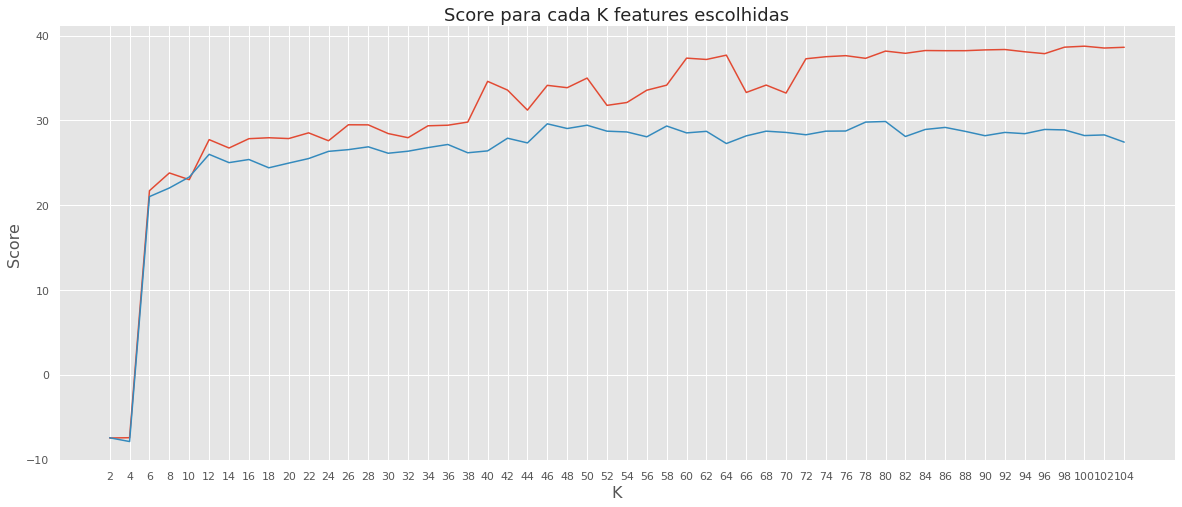

In [40]:
fig, ax = plt.subplots(figsize = (20, 8))
plt.plot(range(2, len(selected_features)+1, 2), K_vs_score_fc_train)
plt.plot(range(2, len(selected_features)+1, 2), K_vs_score_fc_test)
plt.title('Score para cada K features escolhidas', fontsize = 18)
plt.xlabel('K', fontsize = 16)
plt.xticks(range(2, len(selected_features)+1, 2))
plt.ylabel('Score', fontsize = 16) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Cabe resaltar que conforme aumentamos a quantidade de features consideradas alguns indicios de overfitting começam a ser evidentes, isso é bem esperado dado que o aumento de features também aumenta a complexidade no modelo, permitindo modelos mais flexiveis que são mais propensos a overffitar. Com certeza este tipo de comportamento seria mais evidentes em outros tipos de modelos (resaltando que "overffitar um modelo randomforest é quase que um desafio" <- Palavras do Felipe; só que não rsrs)

Fazendo um tradeoff entre melhor preformance vs número de features o experimento indicado seria o de indice 22 (escolha arbitraria), proseguiremos nosso desenvolvimento com esta escolha. Vemos que o metodo é pedorozo que resultamos com uma diminuição do número de features consideradas e um modelo com melhor performance.

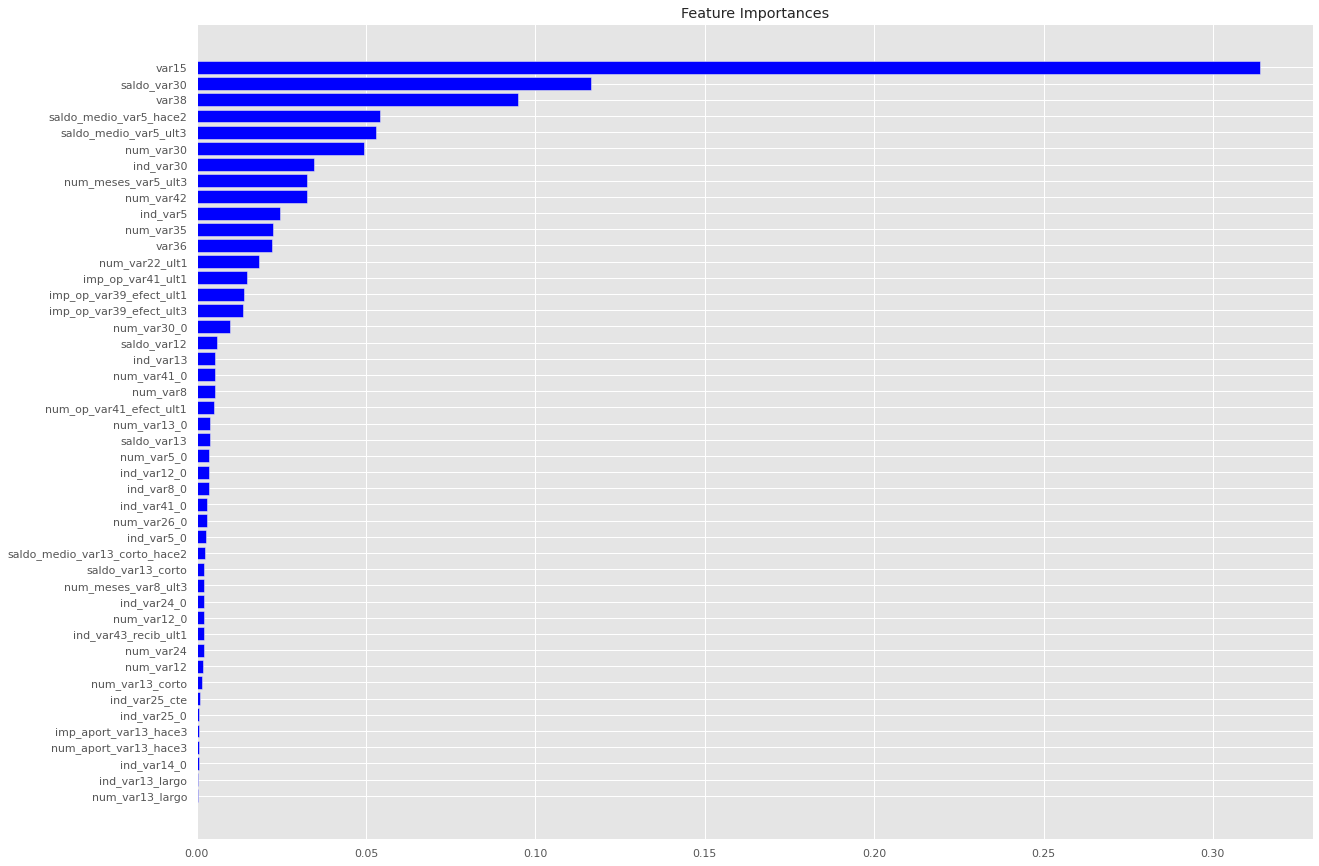

In [56]:


importances = K_estimator[22].feature_importances_
#importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize = (20, 15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [K_features[22][i] for i in indices])
plt.show()

Apresentando a importancia das variaveis observamos que ainda existem algumas que contribuim relativamente pouco ao aprendizado do modelo. 

In [57]:
print('treino:')
show_performance(K_estimator[22], X_train[K_features[22]], y_train)

print('test:')
show_performance(K_estimator[22], X_test[K_features[22]], y_test)

treino:
Matriz de confusão:
[[52641  5769]
 [  944  1462]]

Lucro obtido com a ação (em Reais): R$ 73890 
Lucro maximo possivel: R$ 216540 
Porcentagem do lucro maximo: 34.12%

test:
Matriz de confusão:
[[13145  1457]
 [  262   340]]

Lucro obtido com a ação (em Reais): R$ 16030 
Lucro maximo possivel: R$ 54180 
Porcentagem do lucro maximo: 29.59%



In [138]:
len(K_features[22])

46

In [146]:
model = K_estimator[22]
selected_features = K_features[22]

In [147]:
model.fit(X_train[selected_features], y_train)

print('treino:')
show_performance(model, X_train[selected_features], y_train)

print('test:')
show_performance(model, X_test[selected_features], y_test)

treino:
Matriz de confusão:
[[52641  5769]
 [  944  1462]]

Lucro obtido com a ação (em Reais): R$ 73890 
Lucro maximo possivel: R$ 216540 
Porcentagem do lucro maximo: 34.12%

test:
Matriz de confusão:
[[13145  1457]
 [  262   340]]

Lucro obtido com a ação (em Reais): R$ 16030 
Lucro maximo possivel: R$ 54180 
Porcentagem do lucro maximo: 29.59%



Deixaremos por aqui a parte 1, ficando pendente nos extras (se der tempo) alguns testes obrigatorios como são:
  - Explorar variaveis categóricas
  - Utilizar Underfitting e Overfitting
  - Testar outros modelos XGboost e LightGBM
  - mais feature engineering: combinação de features, criação de novas features, transformação de variaveis, normalização, tratamento dos outliers.
  - Testar criando a variavel de combinação de feature com variancias proximas a zero.

# Parte 2

Nesta parte exploraremos segmentações dos clientes baseado na probabilidade de eles serem insatisfeitos. Estaprobabilidade é obtida a partir da função predit_proba()

Neste casso utilizaremos a metrica AUC para escolher o melhor tradeoff entre TP/FP, levando em conta que o custo de cada TP é diferente ao de um FP

In [59]:
from sklearn.metrics import roc_auc_score as auc

In [148]:
y_prob_test = model.predict_proba(X_test[selected_features])[:,1]
y_prob_train = model.predict_proba(X_train[selected_features])[:,1]

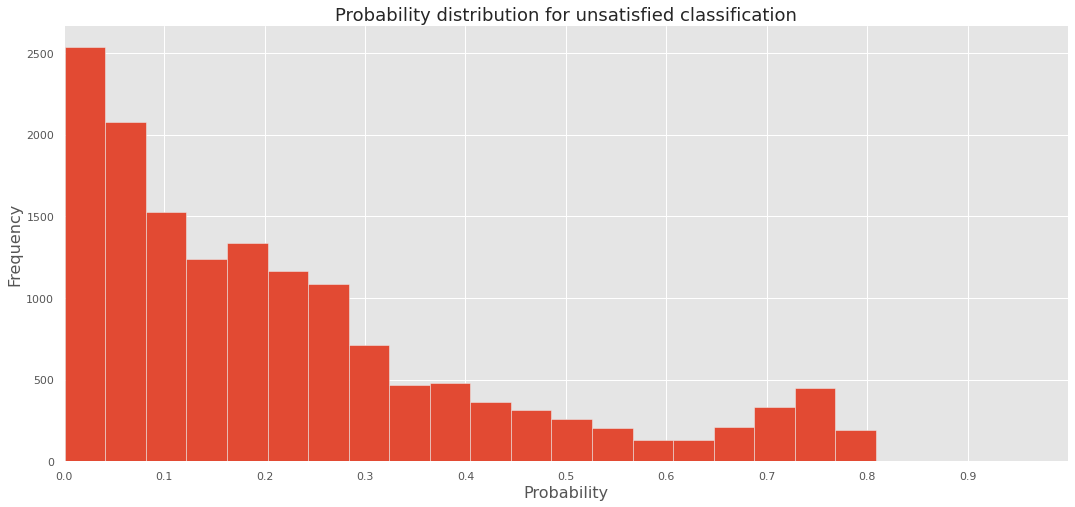

In [61]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.hist(y_prob_test, bins = 20);
ax.set_xlim(0, 1);
plt.xticks(np.arange(0, 1, 0.1))
plt.title('Probability distribution for unsatisfied classification', fontsize=18);
plt.ylabel('Frequency', fontsize=16);
plt.xlabel('Probability', fontsize=16);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

a distribuição mostra que nosso modelo prediz como insatisfeitos aqueles cuja probabilidade seja > 0.5. Dado que este grupo já está bem definido pelo modelo, vamos respeitar este limite para criar nosso primeiro grupo, ou grupo objetivo da campanha de retenção.

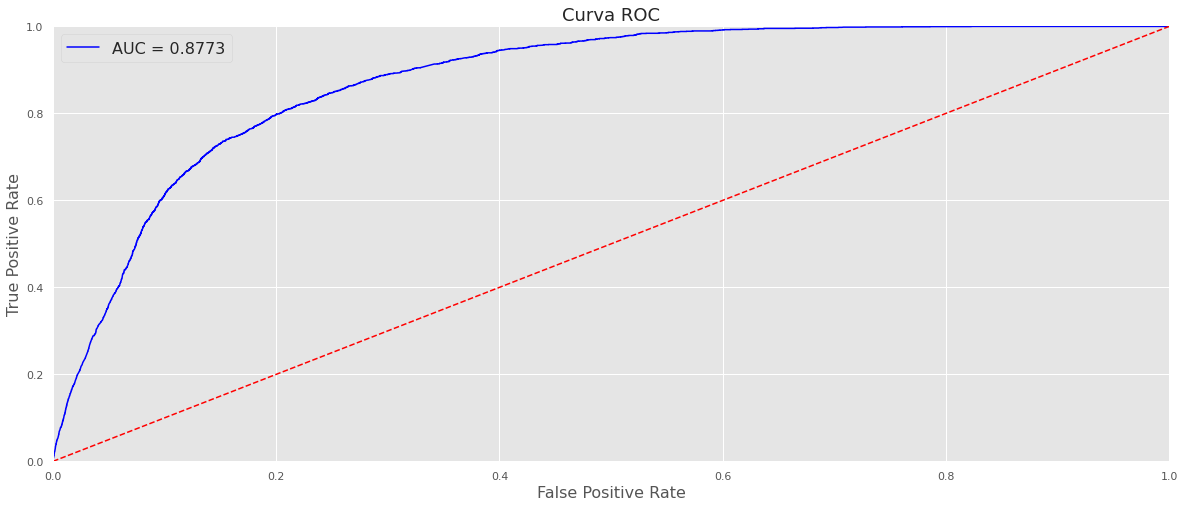

In [63]:
# Code base on this post: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
import sklearn.metrics as metrics

# Calculate FPR and TPR for all thresholds
fpr, tpr, threshold = metrics.roc_curve(y_train, y_prob_train)
roc_auc = metrics.auc(fpr, tpr)

# Plotting the ROC curve
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (20, 8))
plt.title('Curva ROC', fontsize=18)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc = 'upper left', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 16)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.show()

In [62]:
print('auc_train', auc(y_train, y_prob_train))
print('auc_test', auc(y_test, y_prob_test))

auc_train 0.8773190824513788
auc_test 0.844067519536076


A curva ROC é uma visualização poderoza de como nosso modelo está performando em função dos FP e FN. Ela é construida ranqueando os observações segundo as probabilidades calculadas. Conforme for diminuido o nível da probabilidade, são calculadas as frações de FP e FN que entram no nível. Ela serve usualmente para definir o melhor threshold para definir um publico objetivo baseado nas proporções de FP e FN que entram. Neste casso não utilizaremos a curva ROC dado que o custo entre FP e FN não são equivalentes. O ideal no nosso casso seria definir a função de lucro em função do threshold de probabilidade escolhido (conforme apresentado por CaioMar).

<AxesSubplot:xlabel='segmento'>

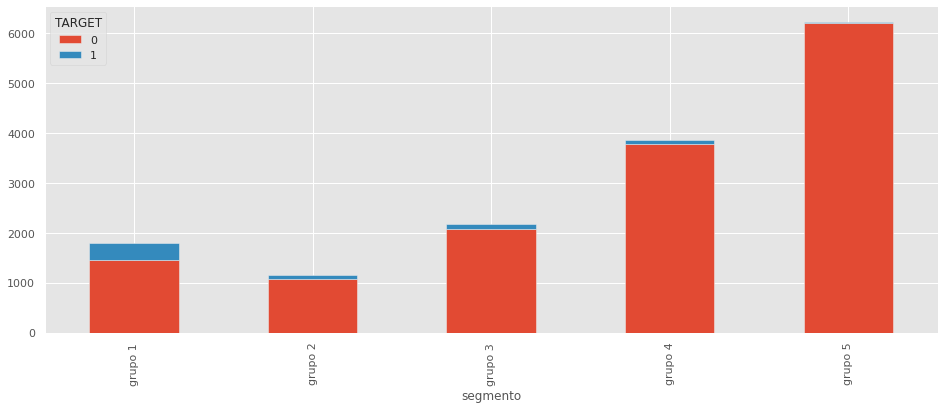

In [171]:
def segmentacao(x):
    delta = 0.5/4
    if x >= 0.5:
        return 'grupo 1'
    if x >= 0.5-delta:
        return 'grupo 2'
    if x >= 0.5-2*delta:
        return 'grupo 3'
    if x >= 0.5-3*delta:
        return 'grupo 4'
    if x >= 0.5-4*delta:
        return 'grupo 5'
    

y_test_aux = y_test.copy()
#y_prob_test

y_prob_test_df = pd.DataFrame(data = y_prob_test, columns = ['y_prob_test'], index = y_test.index.copy())
y_test_aux_out = pd.merge(y_test_aux, y_prob_test_df, how = 'left', left_index = True, right_index = True)

y_test_aux_out['segmento'] = y_test_aux_out['y_prob_test'].apply(lambda x: segmentacao(x))


y_test_aux_out.groupby([target,'segmento']).size().unstack(target).plot.bar(stacked=True,figsize = (16,6))

In [185]:
y_test_aux_out.groupby([target,'segmento']).size()

TARGET  segmento
0       grupo 1     1457
        grupo 2     1073
        grupo 3     2084
        grupo 4     3785
        grupo 5     6203
1       grupo 1      340
        grupo 2       79
        grupo 3       87
        grupo 4       71
        grupo 5       25
dtype: int64

Temos definido os grupos quase que manualmente uma vez sabendo como o nosso modelo está se comportando, no grupo 1 estamos separando os que o modelo tinha classificado como insatisfeitos. Neste casso sabemos que a performance é de 29.59% do ideal do grupo, com lucro de R\$ 16030. Cabe uma escolha mais inteligente de como são divididos os grupos 2 a 5.

In [186]:
340*90 - 1457*10

16030

# Parte 3

Neste casso será utilizado o método de clustering K-means apos um tratamento para reescalar as features. O reescalamento dos dados é necesario devido a que K-means é sensivel a escala.

Tambem seria recomendado utilizar um metodo de redução de dimensionalidade (LDA, PCA, t-SNE) antes de aplicar o clustering, mas neste casso vamos com nossas features escolhidas na parte 1.

Aqui o método consiste de 
- 1. Reescalar as features, 
- 2. Iterar sobre um range escolhido de Ks, enquanto são sapturados os dados de numero de Ks e scores calculados, aqui aproveitamos também para calcular o score da metrica silhouette
(lembrando que o score original no metodo K-means (também conhecido como inercia) é relacionado à somatoria de quadrados intraclusters, enquanto que o score silhouette leva em conta distancia intracluster e interclusters) 
- 3. Representação grafica dos resultados para escolher do melhor K

In [83]:
%%time
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score



scaler = MinMaxScaler()

X_train_scale = pd.DataFrame(scaler.fit_transform(X_train[selected_features]), columns=selected_features)
X_test_scale = pd.DataFrame(scaler.transform(X_test[selected_features]), columns=selected_features)


inertials = []
silhouette_scores = []

for i in range(2, 50):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(X_train_scale)
    inertials.append(kmeans.inertia_)
    score = silhouette_score(X_train_scale, kmeans.labels_)
    silhouette_scores.append(score)

CPU times: user 1h 28min 11s, sys: 27min 50s, total: 1h 56min 2s
Wall time: 57min 59s


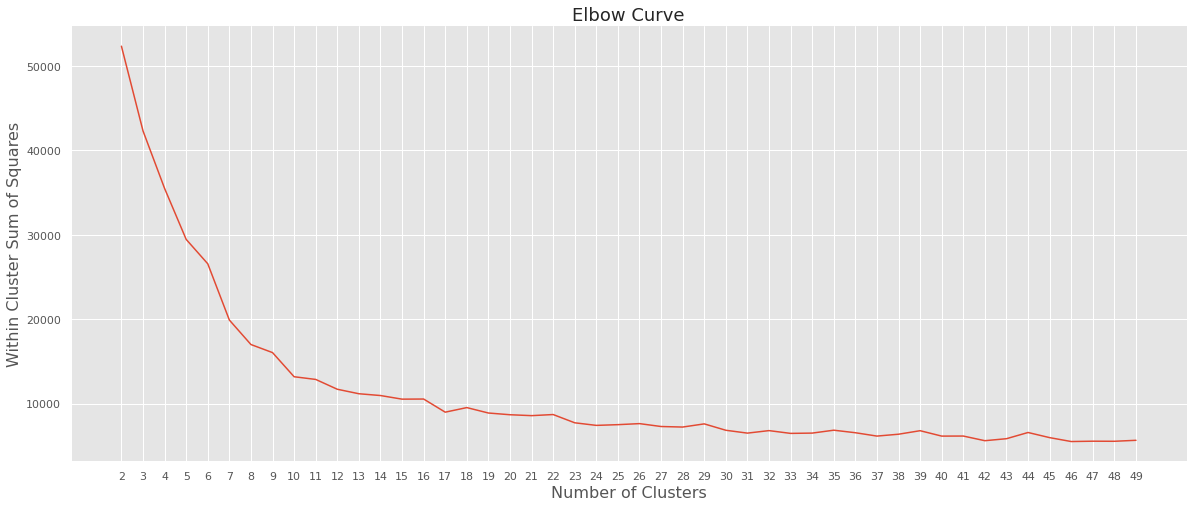

In [84]:
# Elbow Curve
fig, ax = plt.subplots(figsize = (20, 8))
plt.plot(range(2, 50), inertials)
plt.title('Elbow Curve', fontsize = 18)
plt.xlabel('Number of Clusters', fontsize = 16)
plt.xticks(np.arange(2, 50, 1))
plt.ylabel('Within Cluster Sum of Squares', fontsize = 16) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

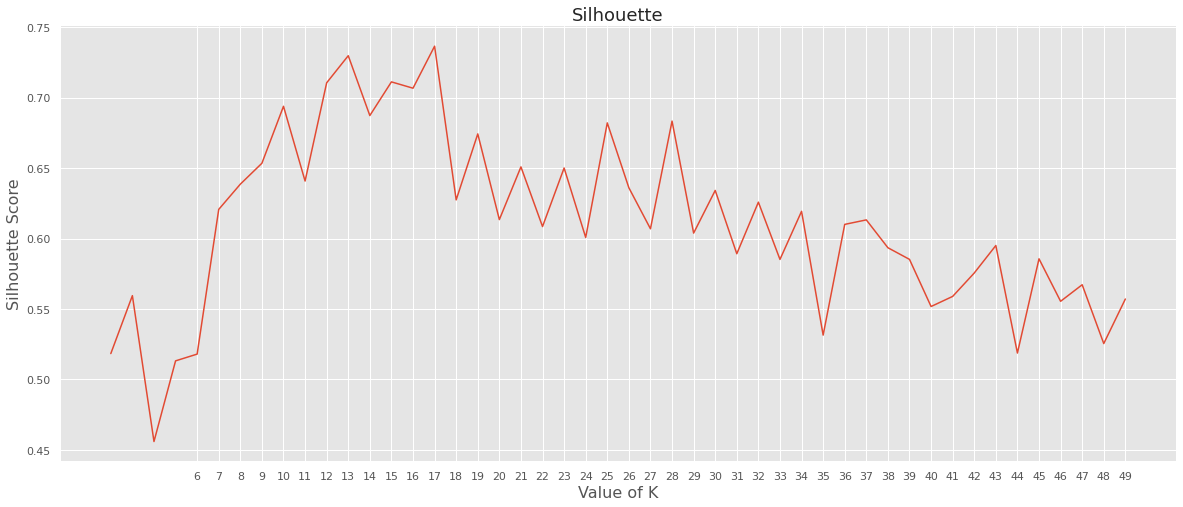

In [86]:
# Silhouette
fig, ax = plt.subplots(figsize = (20, 8))
plt.plot(range(2, 50), silhouette_scores)
plt.title('Silhouette', fontsize = 18)
plt.xlabel('Value of K', fontsize = 16)
plt.xticks(np.arange(6, 50, 1))
plt.ylabel('Silhouette Score', fontsize = 16) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Pelo metodo Silhouette, é evidente que o melhor número de cluster é 13 ou 17 apresentando score aproximados. Ficaremos com 13 pela facilidade de ter menor numero de clusters.

In [102]:
kmeans = KMeans(n_clusters = 17).fit(X_train_scale)

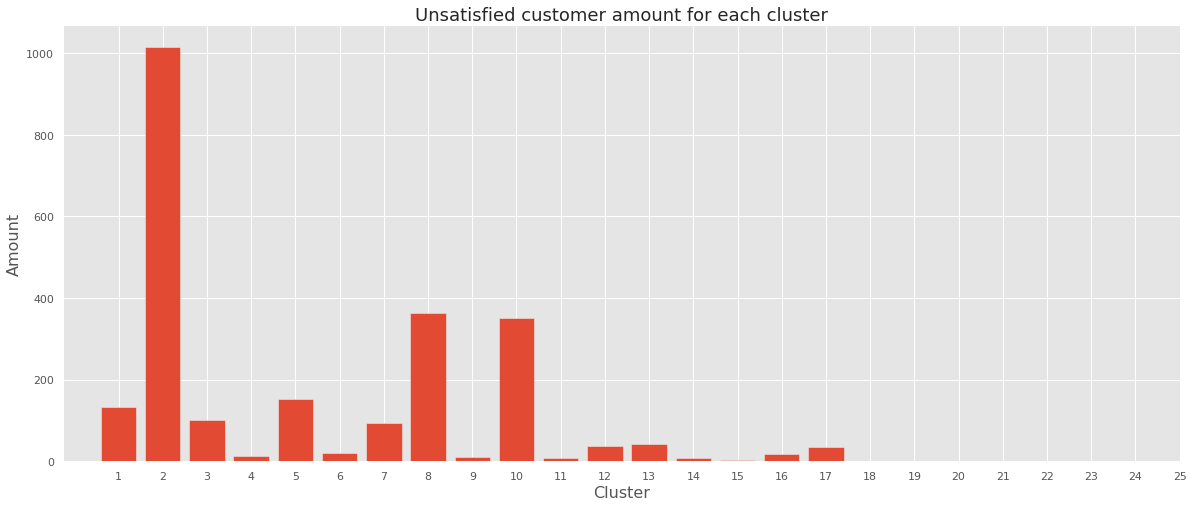

In [103]:
result_kmean_train = pd.DataFrame({'target': y_train, 'labels': kmeans.labels_})
unsatisfied_dist = result_kmean_train[result_kmean_train['target'] == 1].labels.value_counts().sort_index()

# Plotting the unsatified customers ditribution for the clusters
fig, ax = plt.subplots(figsize = (20, 8))
plt.bar(unsatisfied_dist.index + 1, unsatisfied_dist.values);
plt.title('Unsatisfied customer amount for each cluster', fontsize = 18);
plt.xlabel('Cluster', fontsize = 16);
plt.ylabel('Amount', fontsize = 16)
plt.xticks(range(1, 26, 1))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

In [104]:
resumo = pd.crosstab(result_kmean_train['labels'],result_kmean_train['target'])
resumo['lucro'] = resumo[1]*90 - resumo[0]*10
resumo

target,0,1,lucro
labels,,,
0,7522,133,-63250
1,10700,1015,-15650
2,2652,101,-17430
3,1107,14,-9810
4,5335,152,-39670
5,1400,21,-12110
6,1172,95,-3170
7,3338,364,-620
8,1240,10,-11500


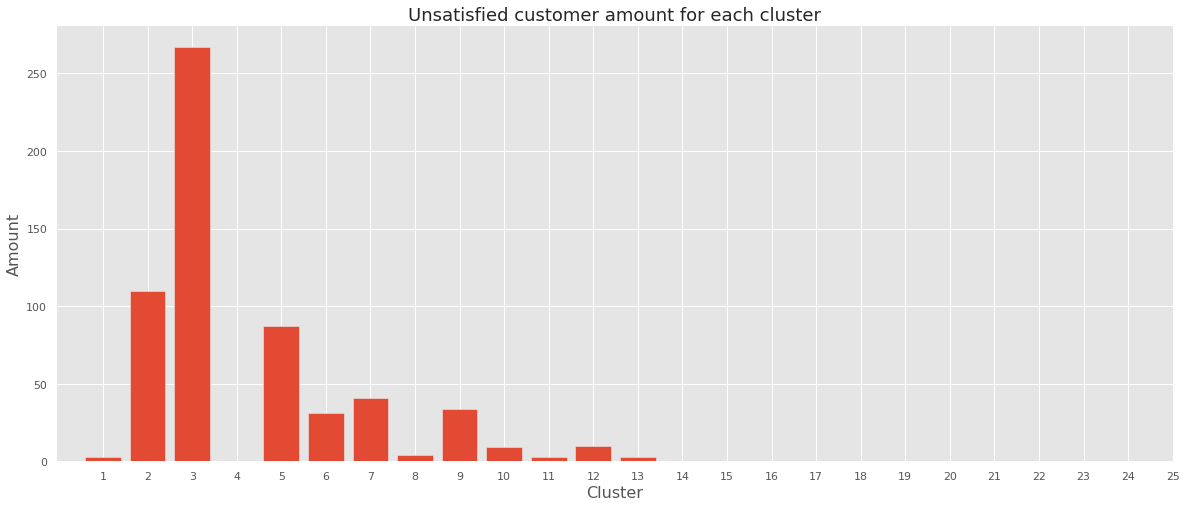

In [92]:
# Get the distribution only for unsatisfied customer on X_test_selected
result_kmean_test = pd.DataFrame({'target': y_test, 'labels': kmeans.predict(X_test_scale)})
unsatisfied_dist_test = result_kmean_test[result_kmean_test['target'] == 1].labels.value_counts().sort_index()

# Plotting the unsatified customers ditribution for the clusters
fig, ax = plt.subplots(figsize = (20, 8))
plt.bar(unsatisfied_dist_test.index + 1, unsatisfied_dist_test.values);
plt.title('Unsatisfied customer amount for each cluster', fontsize = 18);
plt.xlabel('Cluster', fontsize = 16);
plt.ylabel('Amount', fontsize = 16)
plt.xticks(range(1, 26, 1))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

In [105]:
resumo_test = pd.crosstab(result_kmean_test['labels'],result_kmean_test['target'])
resumo_test['lucro'] = resumo_test[1]*90 - resumo_test[0]*10
resumo_test

target,0,1,lucro
labels,,,
0,318,3,-2910
1,5035,110,-40450
2,2741,267,-3380
3,304,0,-3040
4,852,87,-690
5,387,31,-1080
6,1376,41,-10070
7,168,4,-1320
8,1891,34,-15850


Com o conjunto de features escolhidas não observamos que o método de clustering crie um cluster que concentre os clientes insatistefitos. Infelizmente fracazamos nesta tarefa, tentemos uma redução de dimensionalidade antes do agrupamento.

In [ ]:
X_all = data[all_features] 
y_all = data[target]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify = y_all, test_size = 0.20 ,random_state = 1234)

print("Training set has {} samples and {} features.".format(X_train.shape[0], X_train.shape[1]))
print("Testing set has {} samples and {} features.".format(X_test.shape[0], X_test.shape[1]))
print("Train target {:0.5f}%".format(y_train.sum()/y_train.shape[0]))
print("Test target {:0.5f}%".format(y_test.sum()/y_test.shape[0]))


selected_features = list(
                        set(X_train.columns) 
                        - set(zero_variance) 
                        - set(duplicate_vars)
                        - set(features_nzv) 
                        - set(hight_corr)
                        )
len(selected_features)

In [ ]:
n_comp=12
pca = PCA(n_components=n_comp)

X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_train_scale)

print(sum(pca.explained_variance_ratio_))

In [175]:
inertials_2 = [] 
silhouette_scores_2 = []
for i in range(3, 25):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(X_train_pca)
    inertials_2.append(kmeans.inertia_)
    score = silhouette_score(X_train_pca, kmeans.labels_)
    silhouette_scores_2.append(score)
    print(i)

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


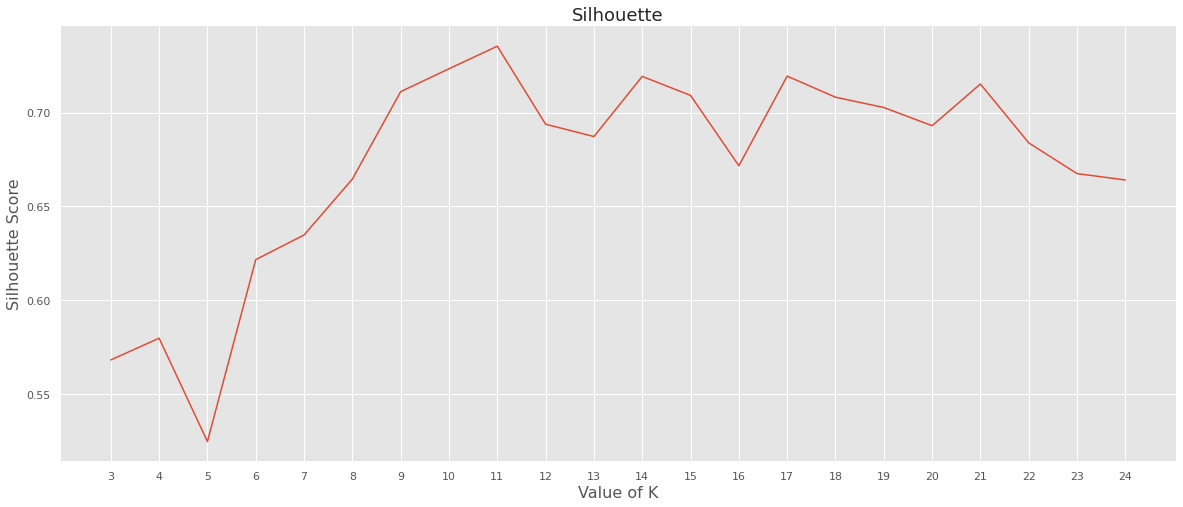

In [178]:
# Silhouette
fig, ax = plt.subplots(figsize = (20, 8))
plt.plot(range(3, 25), silhouette_scores_2)
plt.title('Silhouette', fontsize = 18)
plt.xlabel('Value of K', fontsize = 16)
plt.xticks(np.arange(3, 25))
plt.ylabel('Silhouette Score', fontsize = 16) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [179]:
kmeans_2 = KMeans(n_clusters = 11).fit(X_train_pca)

In [180]:
result_kmean_train_2 = pd.DataFrame({'target': y_train, 'labels': kmeans_2.labels_})
#unsatisfied_dist_2 = result_kmean_train_2[result_kmean_train_2['target'] == 1].labels.value_counts().sort_index()


In [181]:
resumo_2 = pd.crosstab(result_kmean_train_2['labels'],result_kmean_train_2['target'])
resumo_2['lucro'] = resumo_2[1]*90 - resumo_2[0]*10
resumo_2

target,0,1,lucro
labels,,,
0,10700,1015,-15650
1,20275,453,-161980
2,1623,127,-4800
3,7543,136,-63190
4,2460,28,-22080
5,5401,152,-40330
6,3287,60,-27470
7,3340,364,-640
8,1813,12,-17050


In [ ]:
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train[selected_features]), columns=selected_features)
X_test_scale = pd.DataFrame(scaler.transform(X_test[selected_features]), columns=selected_features)


inertials = []
silhouette_scores = []

for i in range(2, 50):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(X_train_scale)
    inertials.append(kmeans.inertia_)
    score = silhouette_score(X_train_scale, kmeans.labels_)
    silhouette_scores.append(score)

# Extra

In [ ]:
def limiar(x, l=0.5):
    if x >= l:
        return 1
    else:
        return 0

thr_test = y_test.to_frame()
thr_test['predicted'] = y_predicted
thr_test['predicted_t'] = thr_test['predicted'].apply(lambda x: limiar(x, 0.5))
max_profit_score(thr_test.TARGET, thr_test.predicted_t)



# Test com tratamento de variaveis categoricas

In [187]:
qtd = get_uniques(X_train[selected_features])
cat_features = list(qtd[(qtd['qtd_unique_values'] >= 3) & (qtd['qtd_unique_values'] <= 10)]['var'])
qtd[(qtd['qtd_unique_values'] >= 3) & (qtd['qtd_unique_values'] <= 10)].reset_index(drop=True)

for i in cat_features:
    print(i, X_train[i].unique())
    

X_v2 = X_all[selected_features].copy()


type_dummies = pd.get_dummies(X_v2[cat_features], columns=cat_features, drop_first=True)
#type_dummies
new_X_all = pd.concat([X_v2.drop(cat_features,axis=1 ),
                      type_dummies],
                      axis=1)
print(new_X_all.shape, type_dummies.shape)

num_var13_0 [ 0  3  6  9 12 18 15]
num_var12 [0 3 6]
num_var41_0 [ 3  0  6  9 12 33 18 21]
num_var26_0 [ 0  3  9  6 33 15 12]
num_var30_0 [  3   9   6   0  12  15  24 114  21  18]
num_var13_corto [0 3 6]
num_aport_var13_hace3 [ 0  6  3 12  9 18]
num_var24 [0 3 6]
num_var13_largo [ 0  6  3  9 12 18 15]
num_var12_0 [  0   3   6   9 111]
var36 [99  2  3  1  0]
num_var30 [ 3  0  6  9 12 15 21 18]
num_meses_var8_ult3 [0 1 2 3]
num_var42 [ 3  0  6  9 12]
num_var5_0 [3 0 6 9]
num_meses_var5_ult3 [1 3 0 2]
(76020, 115) (76020, 85)


In [188]:
type_dummies.shape

(76020, 85)

In [189]:
X_train, X_test, y_train, y_test = train_test_split(new_X_all, y_all, stratify = y_all, test_size = 0.20 ,random_state = 1234)

print("Training set has {} samples and {} features.".format(X_train.shape[0], X_train.shape[1]))
print("Testing set has {} samples and {} features.".format(X_test.shape[0], X_test.shape[1]))
print("Train target {:0.5f}%".format(y_train.sum()/y_train.shape[0]))
print("Test target {:0.5f}%".format(y_test.sum()/y_test.shape[0]))

Training set has 60816 samples and 115 features.
Testing set has 15204 samples and 115 features.
Train target 0.03956%
Test target 0.03959%


In [190]:
len(X_train.columns)

115

In [ ]:
    gsearch = GridSearchCV(estimator=RandomForestClassifier(random_state=1234, n_jobs=-1), 
                           param_grid = {'max_depth':[18],
                                         'n_estimators':[47],
                                         'criterion': ['gini'],
                                         'class_weight':[{0:1,1:12}, {0:1,1:13}, {0:1,1:14}], 
                                         'min_samples_split':[int(X_train.shape[0]*0.01),
                                                              int(X_train.shape[0]*0.005)],
                                         'max_features':['auto','log2',40]
                                         }, 
                           scoring=max_profit_scorer, 
                           cv=skf.split(X_train_selected_fc, y_train), 
                           n_jobs=-1, 
                           verbose=0)
    
    gsearch.fit(X_train_selected_fc, y_train)
    bst_max_profit_model = gsearch.best_estimator_
    K_estimator.append(bst_max_profit_model)
    
    y_train_pred = bst_max_profit_model.predict(X_train_selected_fc)
    y_test_pred = bst_max_profit_model.predict(selector_fc.transform(X_test_clean))

    y_train_optime = max_profit_score(y_train, y_train)
    y_test_optime = max_profit_score(y_test, y_test)
    
    K_vs_score_fc_train.append(100*max_profit_score(y_train, y_train_pred)/y_train_optime)
    K_vs_score_fc_test.append(100*max_profit_score(y_test, y_test_pred)/y_test_optime)
    

    end = time()
    # Returning the metrics related to the tested K and the time spent on this iteration of the loop
    print("index {}: -  k = {} - lucro_train = {} - lucro_test = {} - Time = {}s".format(len(K_vs_score_fc_train)-1, k, K_vs_score_fc_train[-1], K_vs_score_fc_test[-1], end-start))

In [192]:
%%time
param_grid = {'max_depth':[18],
              'n_estimators':[47],
              'criterion': ['gini'],
              'class_weight':[{0:1,1:12},
                              {0:1,1:13},
                              {0:1,1:14}], 
              'min_samples_split':[int(X_train.shape[0]*0.01),
                                   int(X_train.shape[0]*0.005)],
              'max_features':['auto','log2',40]
             }


skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1234)

gsearch = GridSearchCV(RandomForestClassifier(random_state=1234, n_jobs=-1), 
                       param_grid={'max_depth':[18],
                                   'n_estimators':[47],
                                   'criterion': ['gini'],
                                   'class_weight':[{0:1,1:12},
                                                   {0:1,1:13},
                                                   {0:1,1:14}], 
                                   'min_samples_split':[int(X_train.shape[0]*0.01),
                                                        int(X_train.shape[0]*0.005)],
                                   'max_features':['auto','log2',40]
                                  }, 
                       scoring=max_profit_scorer, 
                       cv=skf.split(X_train, y_train), 
                       n_jobs=-1, 
                       verbose=5)

gsearch.fit(X_train, y_train)


bst_max_profit_model = gsearch.best_estimator_
print('treino:')
show_performance(bst_max_profit_model, X_train, y_train)

print('test:')
show_performance(bst_max_profit_model, X_test, y_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.4min finished


treino:
Matriz de confusão:
[[51921  6489]
 [  814  1592]]

Lucro obtido com a ação (em Reais): R$ 78390 
Lucro maximo possivel: R$ 216540 
Porcentagem do lucro maximo: 36.20%

test:
Matriz de confusão:
[[12934  1668]
 [  250   352]]

Lucro obtido com a ação (em Reais): R$ 15000 
Lucro maximo possivel: R$ 54180 
Porcentagem do lucro maximo: 27.69%

CPU times: user 14.1 s, sys: 278 ms, total: 14.4 s
Wall time: 2min 29s


In [193]:
%%time

new_X_all['random'] = np.random.randint(20, size=new_X_all.shape[0])

X_train, X_test, y_train, y_test = train_test_split(new_X_all, y_all, stratify = y_all, test_size = 0.20 ,random_state = 1234)

CPU times: user 120 ms, sys: 4.54 ms, total: 124 ms
Wall time: 123 ms


In [195]:
print("Training set has {} samples and {} features.".format(X_train.shape[0], X_train.shape[1]))
print("Testing set has {} samples and {} features.".format(X_test.shape[0], X_test.shape[1]))
print("Train target {:0.5f}%".format(y_train.sum()/y_train.shape[0]))
print("Test target {:0.5f}%".format(y_test.sum()/y_test.shape[0]))

param_grid = {'max_depth':[18],
              'n_estimators':[47],
              'criterion': ['gini'],
              'class_weight':[{0:1,1:12},
                              {0:1,1:13},
                              {0:1,1:14}], 
              'min_samples_split':[int(X_train.shape[0]*0.01),
                                   int(X_train.shape[0]*0.005)],
              'max_features':['auto','log2',40]
             }


skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1234)

gsearch = GridSearchCV(RandomForestClassifier(random_state=1234, n_jobs=-1), 
                       param_grid=param_grid, 
                       scoring=max_profit_scorer, 
                       cv=skf.split(X_train, y_train), 
                       n_jobs=-1, 
                       verbose=5)

gsearch.fit(X_train, y_train)


bst_max_profit_model = gsearch.best_estimator_
print('treino:')
show_performance(bst_max_profit_model, X_train, y_train)

print('test:')
show_performance(bst_max_profit_model, X_test, y_test)

Training set has 60816 samples and 116 features.
Testing set has 15204 samples and 116 features.
Train target 0.03956%
Test target 0.03959%
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.4min finished


treino:
Matriz de confusão:
[[52399  6011]
 [  867  1539]]

Lucro obtido com a ação (em Reais): R$ 78400 
Lucro maximo possivel: R$ 216540 
Porcentagem do lucro maximo: 36.21%

test:
Matriz de confusão:
[[13070  1532]
 [  261   341]]

Lucro obtido com a ação (em Reais): R$ 15370 
Lucro maximo possivel: R$ 54180 
Porcentagem do lucro maximo: 28.37%



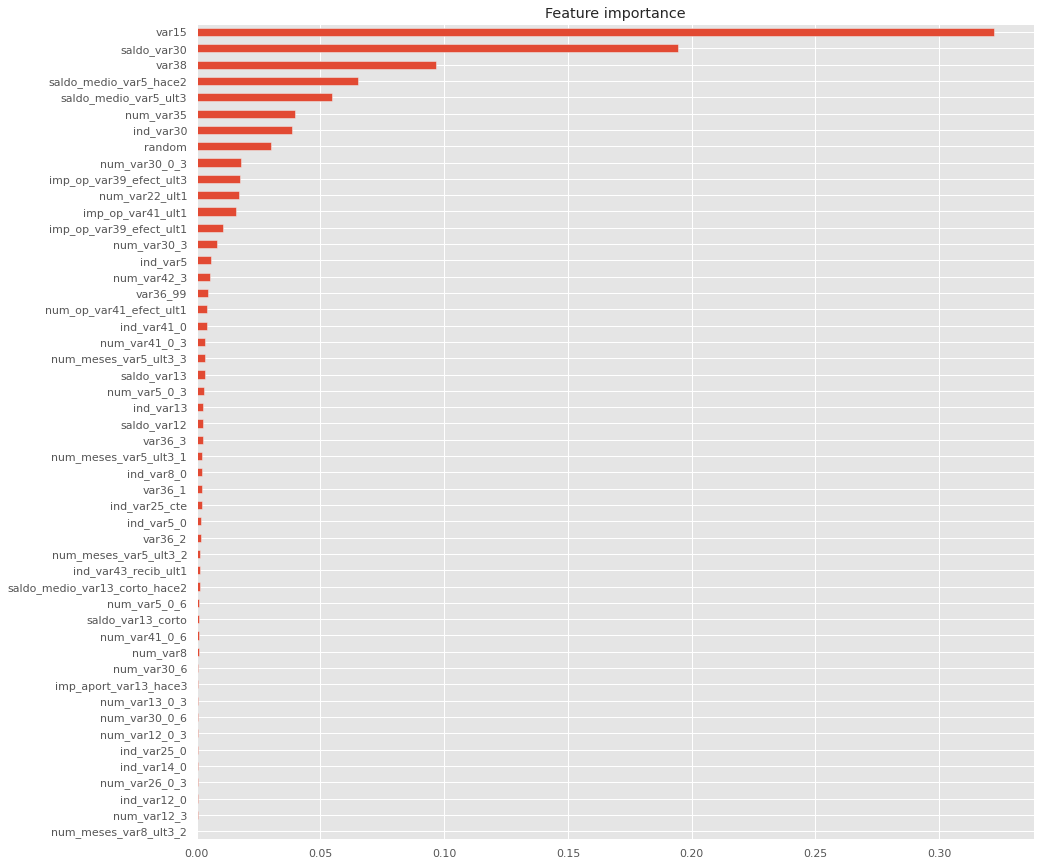

In [196]:
feat_imp = pd.Series(bst_max_profit_model.feature_importances_, index=X_train.columns)
feat_imp.sort_values(inplace=True)
ax = feat_imp.tail(50).plot(kind='barh', figsize=(15,15), title='Feature importance')

O resultado anterior nos mostra que, das variaveis categoricas não existe alguma que resulte com importancia melhor que a variavel random. Inacreditavel!!

In [197]:
feat_imp.sort_values(ascending= False, inplace=True)

feat_imp_df = pd.DataFrame(feat_imp).reset_index().reset_index()
feat_imp_df.columns = ['pos', 'var', 'imp']
important = feat_imp_df[feat_imp_df['pos'] < int(feat_imp_df[feat_imp_df['var'] == 'random']['pos'])]
important

,pos,var,imp
0,0,var15,0.322114
1,1,saldo_var30,0.194644
2,2,var38,0.096660
3,3,saldo_medio_var5_hace2,0.065290
4,4,saldo_medio_var5_ult3,0.054800
5,5,num_var35,0.039771
6,6,ind_var30,0.038580


# Undersampling e Oversampling

Para os testes de OverSampler e Undersampler utilizamos a biblioteca imblearn a qual possui a implementação dos metodos RandomOverSampler, RandomUnderSampler

In [199]:
X_all = data[all_features] 
y_all = data[target]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify = y_all, test_size = 0.20 ,random_state = 1234)

print("Training set has {} samples and {} features.".format(X_train.shape[0], X_train.shape[1]))
print("Testing set has {} samples and {} features.".format(X_test.shape[0], X_test.shape[1]))
print("Train target {:0.5f}%".format(y_train.sum()/y_train.shape[0]))
print("Test target {:0.5f}%".format(y_test.sum()/y_test.shape[0]))


selected_features = list(
                        set(X_train.columns) 
                        - set(zero_variance) 
                        - set(duplicate_vars)
                        - set(features_nzv) 
                        - set(hight_corr)
                        )
len(selected_features)

Training set has 60816 samples and 369 features.
Testing set has 15204 samples and 369 features.
Train target 0.03956%
Test target 0.03959%


104

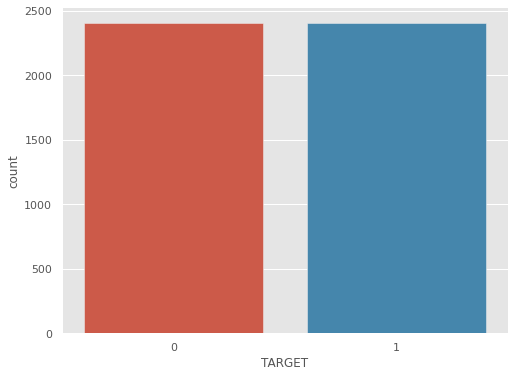

In [200]:
#!pip install imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_train = X_train[selected_features]
y_train = y_train
X_resampled, y_resampled = rus.fit_resample(X_train, y_train) 
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(y_resampled);

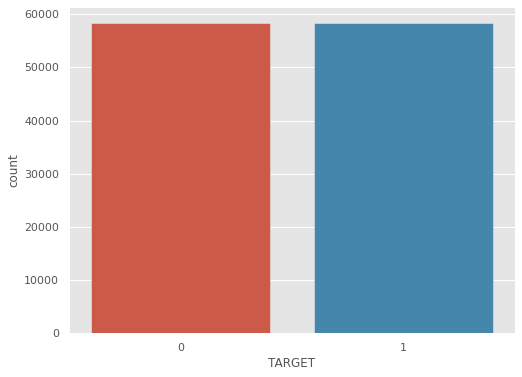

In [201]:
ros = RandomOverSampler(random_state = 0)
X_rosampled, y_rosampled = ros.fit_resample(X_train,y_train) 
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(y_rosampled);

In [203]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled , test_size=0.20, random_state=1234)
print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)



param_grid = {'max_depth':[14, 16, 18],
              'n_estimators':[40, 45, 47],
              'criterion': ['gini'],
              'min_samples_split':[int(X_train.shape[0]*0.01),
                                   int(X_train.shape[0]*0.005)],
              'max_features':['auto','log2',40]
             }


skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1234)

gsearch = GridSearchCV(RandomForestClassifier(random_state=1234, n_jobs=-1), 
                       param_grid={'max_depth':[14, 16, 18],
                                   'n_estimators':[40, 45, 47],
                                   'criterion': ['gini'],
                                   'min_samples_split':[int(X_train.shape[0]*0.01),
                                                       int(X_train.shape[0]*0.005)],
                                   'max_features':['auto','log2',40]
                                   }, 
                       scoring=max_profit_scorer, 
                       cv=skf.split(X_train, y_train), 
                       n_jobs=-1, 
                       verbose=5)

gsearch.fit(X_train, y_train)


bst_max_profit_model = gsearch.best_estimator_
print('treino:')
show_performance(bst_max_profit_model, X_train, y_train)

print('test:')
show_performance(bst_max_profit_model, X_test, y_test)

(963, 104) (963,)
(3849, 104) (3849,)
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   43.8s finished


treino:
Matriz de confusão:
[[1605  296]
 [ 293 1655]]

Lucro obtido com a ação (em Reais): R$ 145990 
Lucro maximo possivel: R$ 175320 
Porcentagem do lucro maximo: 83.27%

test:
Matriz de confusão:
[[388 117]
 [103 355]]

Lucro obtido com a ação (em Reais): R$ 30780 
Lucro maximo possivel: R$ 41220 
Porcentagem do lucro maximo: 74.67%

CPU times: user 2.86 s, sys: 196 ms, total: 3.05 s
Wall time: 44.6 s


In [ ]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X_rosampled,y_rosampled , test_size=0.20, random_state=1234)
print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)



skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1234)

gsearch = GridSearchCV(RandomForestClassifier(random_state=1234, n_jobs=-1), 
                       param_grid={'max_depth':[14, 16, 18],
                                   'n_estimators':[40, 45, 47],
                                   'criterion': ['gini'],
                                   'min_samples_split':[int(X_train.shape[0]*0.01),
                                                       int(X_train.shape[0]*0.005)],
                                   'max_features':['auto','log2',40]
                                   }, 
                       scoring=max_profit_scorer, 
                       cv=skf.split(X_train, y_train), 
                       n_jobs=-1, 
                       verbose=5)

gsearch.fit(X_train, y_train)


bst_max_profit_model = gsearch.best_estimator_
print('treino:')
show_performance(bst_max_profit_model, X_train, y_train)

print('test:')
show_performance(bst_max_profit_model, X_test, y_test)

(23364, 104) (23364,)
(93456, 104) (93456,)
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.2min


o resultado do nosso GridSearchCV nos da os melhores hiperparametros possiveis para o nosso melhor modelo, agora tomaremos alguma ações de feature enginering mantendo estes hiperparametros constantes a fim de determinar se nossas ações melhoraram/atrapalharam nosso modelo.

- A primeira ação será dar uma olhada rapida nas categorias possiveis sobre cada coluna, isso nos permitira identificar variaveis sem variancia, e também teremos uma leve noção de quais variaveis podem ser categoricas e quais numericas.

- de fato existem features sem variancia, estas não aportam informação discrimante para o nosso modelo, pelo qual procederemos a retira-las do dataset

- A segunda ação que executaremos será de remover variaveis duplicadas. Para isso barremos cada feature comparandola com todas as outras, esta comparação será feita pela utilização da função array_equal do numpy
- Comparamos pares de variaveis em ordem ascendente, se é comprovado que existem variaveis duplicadas adicinaremos a segunda a um diccionario, aqui tomamos o cuidado de não executar a comparação sobre variaveis que já foram identificadas para ser removidas (evitemos dores de cabeça).

mmm, aqui é um bom momento para refletir, nosso modelo piorou mas ele possui menos variaveis, só foram retiradas variaveis duplicadas tomando o cuidado de deixar pelo menos 1 das que possuim a informação duplicada. Vale a pena deixar variaveis duplicadas sendo que isso não faz sentido? acho que não... Continuareremos com o modelo só com 1 das variaveis duplicadas. Por que? porque desde o ponto de vista conceitual, não existe motivo algum para ter um modelo melhor só pelo fato de ter replicado algumas colunas. OK? Não ficou claro? acredito fortemente que mexendo nos hiperparametros este dataset dará igual ou melhor resultado que o anterior que possui variaveis duplicadas. Vamos na frente.

OK, OK, pensemos no que pode estar acontecendo. Antes de entrar no desespero pensemos, estamos diminuindo a variancia do nosso modelo, porque está melhorando no treindo e piorando no teste? pode ser que estamos tirando informação importante, mas como pode ser que estamos tirando informação se a variancia é quase zero. Ok não será que estamos esquecendo de alguma coisa... tipo: outliers? testemos tirar eles do nosso dataset

- Apos retirar as variaveis duplicadas vemos que aumentou um pouco mais o porcentagem do lucro ideal

- identificamos algumas variaveis com variancia 0, retiramos estas variaveis do dataset dado que não aportam nenhum tipo de informação

- identificamos algumas variaveis binarias, outras categoricas e demais continuas, separamos elas para respectivas análises

- quais variáveis serão dummizadas -> exclusão das que possuem muitas categorias

- Método para limpar colunas da base treino identificando as variáveis categóricas com variância próxima de zero, no caso todas em que a relação entre a primeira e segunda categoria é de 99 para 1.

# Referências
- Trabalho do Caio Martins https://github.com/CaioMar/certificao_data_masters/blob/master/Certificacao%20Data%20Masters.ipynb
- Trabalho do PedroHCouto https://github.com/PedroHCouto/Santander-Case/blob/master/Part%20A%20-%20Classification.ipynb
- Random Forest Classifier and its Hyperparameters https://medium.com/analytics-vidhya/random-forest-classifier-and-its-hyperparameters-8467bec755f6
- Hyperparameter Tuning the Random Forest in Python https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- Random Search vs Grid Search for hyperparameter optimization https://towardsdatascience.com/random-search-vs-grid-search-for-hyperparameter-optimization-345e1422899d
- Optimizing Hyperparameters the right Way https://towardsdatascience.com/optimizing-hyperparameters-the-right-way-3c9cafc279cc
- How to Use ROC Curves and Precision-Recall Curves for Classification in Python
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- Step by Step to Understanding K-means Clustering and Implementation with sklearn https://medium.com/data-folks-indonesia/step-by-step-to-understanding-k-means-clustering-and-implementation-with-sklearn-b55803f519d6